<h1 align=center>Leverage Causes Fat Tails and Clustered Volatility</h1>

Note: this version of the notebook aims at reproducing the results without specifying tasks for the students. The plan is to formulate the questions after having successfully reproduced the results.

<h2>Introduction</h2>
One of the most popular assumptions in finance is the efficient market hypothesis, which is closely related to the assumption of rational expectations in economics. Both posit that - at least at aggregate - agents act in their best, long-term interest given their preferences and all available information. These assumptions provide many methodological advantages, most notably clear criteria about how agents should behave. Unfortunately, they fail to explain the bubbles that can sometimes be observed in reality. Many attempts have been made to construct theories of "rational bubbles" (e.g. by Blanchard, TODO: add references) in order to reconcile this discrepancy, but they are usually depend on special interpretations of the word "bubble". As long as a bubble is understood as an irrationally high price, it cannot be rational by definition.

A more fruitful approach to reason about the nature of bubbles and related phenomena such a fat tails and clustered volatility is to test the macro-effects of known micro-behavior regardless of rationality. One such micro-behavior that can lead to steep declines of market prices is leverage. It can help to explain the dynamics of bursting bubbles in financial markets, with prices being driven lower and lower as a cascade of overleveraged traders are forced by their creditors to liquidate their positions. 

This notebook reproduces the results of the 2013 paper <a href="http://www.uvm.edu/~cmplxsys/legacy/newsevents/pdfs/2013/thurner-volatility-finance.pdf"><em>Leverage Causes Fat Tails and Clustered Volatility</em></a> by Thurner, Farmer and Geanakoples. The model demonstrates how excessive leverage can trigger dramatic sell-offs in financial markets that drive the price deep below fundamental value.

<h2>Model Overview</h2>
The model consists of three connected mechanisms. First, there is a noise trader that buys and sells stocks every day without much of a plan. It is constructed such that the stock market follows a random walk with a bias towards the fundamental value. Second, there are a number of leveraged funds following a value strategy. They enter the market when it is below its fundamental value and exit it again when it is above. Third, there are background investors that rebalance their investments between the funds depending on recent performance. They balance the model as a whole by continuously withdrawing liquidity from the funds in order to prevent them from growing too large and dominating the market relative to the noise traders.

<h2>The Noise Trader</h2>
The behavior of the noise trader is modeled around the <em>cash value</em> $\xi_{nt}(t)$ the trader has invested in the stock market at time $t$. It is specified such that it follows the autoregressive random process described by equation 1. In absence of other traders, it makes the price $p(t)$ of the only stock follow a mean-reverting random walk.

\begin{align}
    log(\xi_{nt}(t)) = \rho~log(\xi_{nt}(t-1)) + \sigma \chi(t) + (1-\rho)log(NV) \tag{1}
\end{align}    

Parameters $\rho=0.99$ and $\sigma=0.035$ are constant, with $\chi(t)\sim\mathcal{N}(0, 1)$ being a standard-normal random variable. The <em>fundamental value</em> $V$ of each of the $N=1000$ shares is constant with $V=1$. Thus, $NV$ represents the total fundamental value of the stock market and the anchor for the mean-reversion. In absence of other traders, the expected amount the noise trader has invested in the stock market matches the fundamental value $NV$:

\begin{align}
    E[log(\xi_{nt})] = log(NV)
\end{align}

Market clearing further dictates $\xi_{nt}=Np$ and therefore $E[log(p)] = log(V)$ for the price $p(t)$ of a single share.

As a first step, we will simulate the noise trader in isolation to get a more intuitive understanding of its behavior and the resulting prices.

In [11]:
# Set the constants
rho = 0.99
sigma = 0.035
N = 1000
V = 1

In [12]:
# load and configure required module
%load_ext autoreload
%autoreload 2

import math
import numpy # numerics
from scipy import optimize # we use their root finding algorithm
import matplotlib.pyplot as plot
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# Function for noise trader's investment given the previous value (equation 1)
def calculateNoiseTraderInvestment(previousInvestment):
    return math.exp(rho * math.log(previousInvestment) + sigma * numpy.random.normal() + (1-rho)*math.log(N*V))

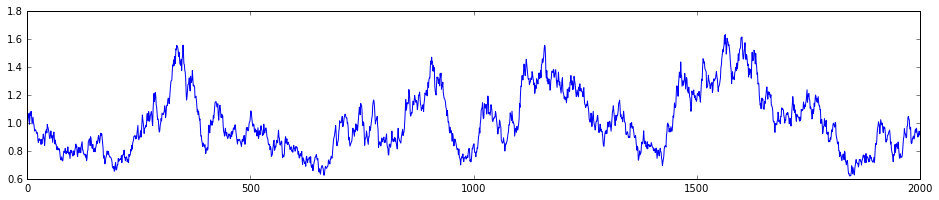

In [14]:
# Create and plot price time series

def createNoiseTraderTimeSeries(length):
    investment = N*V # start value
    prices = [investment / N]
    while len(prices) < length:
        investment = calculateNoiseTraderInvestment(investment)
        prices.append(investment / N)
    return prices

plot.figure(figsize=(16,3))
plot.plot(createNoiseTraderTimeSeries(2000))
plot.show()

Next, let us verify some selected statistical properties of the noise trader's time series to make sure everything works as expected.

In [15]:
# The average of prices is a few percent above the fundamental value. So at average, the noise trader tends to
# overvalue the stocks. This is an artefact of using a log-based random walk and does not bother us much.

longRun = 100000
prices = createNoiseTraderTimeSeries(longRun)
sum(prices)/len(prices)

1.0208199438473167

In [16]:
# Log prices meander around zero as specified. Increase the definition of longRun to get more precise results.

longRun = 100000
prices = createNoiseTraderTimeSeries(longRun)
logPrices = list(map(lambda x : math.log(x), prices))
sum(logPrices)/len(logPrices)

-0.004097361936828058

In [17]:
# Verify that in the long run, returns are slightly negatively autocorrelated due to mean-reversion.
# This is the opposite of having momentum (which can be observed in the real stock market).
# With mean-reversion, the price is a little more likely to go down at time t+1 if it went up at time t.

def calculateLogReturn(x, y):
    return math.log(x/y)

def calculateLogReturns(prices):
    length = len(prices)
    return list(map(calculateLogReturn, prices[0:length-1], prices[1:length]))

def calculateAutocorrelation(returns, lag):
    length = len(returns)
    return numpy.corrcoef(returns[0:length-lag], returns[lag:length])[0][1]

longRun = 100000
prices = createNoiseTraderTimeSeries(longRun)
returns = calculateLogReturns(prices)

# This should output a slightly negative value. If not, you have been unlucky and should run it again. :)
calculateAutocorrelation(returns, 1)

-0.0021320137216301054

<h2>Investment Funds</h2>
<h3>Specification</h3>
As a next step, investments funds following a value strategy are added to the model. Each fund $h$ has wealth $W_h(t) = \xi_h(t) + C_h(t)$, consisting of a stock market investment $\xi_h$ and cash $C_h$. Cash can be negative when the fund is leveraged. All funds base their decisions on the same mispricing signal

\begin{align}
    m(t) = V - p(t) \tag{2}
\end{align}

whereas a positive $m(t)$ signals that the stock market is undervalued. As long as the market is overvalued (i.e. $m(t) \leq 0$), the funds do not hold any stocks. However, as soon as an undervaluation is detected, funds hold $\xi_h(t)$ worth of stocks, which depends on the magnitude of the signal as well as the funds wealth:

\begin{align}
    \xi_h(t) = min\big(~\beta_h m(t),~\lambda_{MAX}\big)~W_h(t) \tag{3}
\end{align}

The maximum leverage $\lambda_{MAX}$ is later varied between simulation runs to investigate how it affects the aggregate outcome. The parameter $\beta_h$ varies between funds and specifies how aggressively a fund to the buy signal.

It is key to understand that the wealth $W_h(t)$ of a fund depends on the current prices. Thus, once a fund is fully leveraged, a further decline of $p(t)$ will lead to a decreased investment $\xi_h(t)$, which can push the price down even further.


In [133]:
# Since we will have multiple different funds, it makes sense to define a Fund class to encapsulate their state.
# This is classic object-oriented programming, as opposed to the procedural programming above. The fund class
# defines funds in terms of capabilities (methods) and state (variables). In a clean object-oriented design, the
# state should be strictly internal and not be directly accessible from the outside.
class Fund:
    
    # Defining parameters shared by all Funds
    initialWealth = 2 # named beta in the equation-based version of the model
    maxLeverage = 100  # named lambda_max in the equation-based version of the model
    
    def __init__(self, aggressiveness):
        self.aggressiveness = aggressiveness
        self.cash = self.initialWealth  # W_h(0) in the equation-based model
        self.shares = 0
        self.activationDelay = 0
             
    def checkBankrupt(self, price):
        if self.isActive():
            # check for bankrupty
            if self.getWealth(price) <= self.initialWealth * 0.1:
                self.shares = 0
                self.cash = self.initialWealth
                self.activationDelay = 100 # the fund is bankrupt and will resurrect in 100 days
                return True
            else:
                return False
        else: 
            self.activationDelay = self.activationDelay - 1
            return False
            
    # returns true if the fund is not bankrupt
    def isActive(self):
        return self.activationDelay == 0;
    
    def getWealth(self, price): 
        return max(0, self.cash + self.shares * price);
    
    # returns the number of shares the fund would like to hold at the given price
    def getDemand(self, price):
        if self.isActive():
            m = V - price # equation 2
            if (m < 0):
                return 0
            
            # equation 3 divided by price
            leverage = min(self.aggressiveness * m, self.maxLeverage)
            return leverage * self.getWealth(price) / price
        else:
            return 0
    
    # updates the fund's holdings by trading at the given price
    def trade(self, price):
        if self.isActive():
            wealth = self.getWealth(price)
            self.shares = self.getDemand(price)
            self.cash = wealth - self.shares * price
        
        


<h3>Testing the Funds</h3>

Having defined a fund class, let us test it.

In [19]:
# For example, a newly created fund should invest at most 20 = maxLeverage * initialWealth

Fund.maxLeverage = 10
testFund = Fund(25)
price = 0.27
investment = testFund.getDemand(price) * price
"investment at " + str(price) + " is " + str(investment)

'investment at 0.27 is 20.000000000000004'

Any idea what went wrong with the test above? How is a leverage above maxLeverage possible?

As a next step, we will reproduce figure 1 from the paper, but with price $p$ on the x-axis instead of signal $m$. The y-axis shows investmen $\xi_h$. Parameters are set to $\lambda_{max}=50$ and $\beta_h=100$.

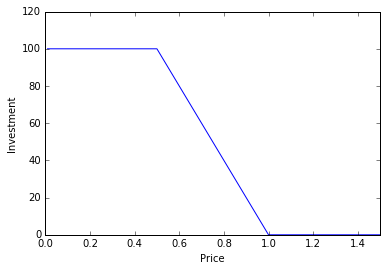

In [20]:
Fund.maxLeverage = 50
testFund = Fund(100)

prices = []
demand = []
for i in range(-99, 100):
    price = V + i / 100
    investment = testFund.getDemand(price) * price
    prices.append(price)
    demand.append(investment)
    
plot.xlabel('Price')
plot.ylabel('Investment')
plot.axis([0.0, 1.5, 0, 120])
plot.plot(prices, demand)
plot.show()

<h2>Market Clearing</h2>

Market clearing dictates that supply must match demand:

\begin{align}
    \xi_{nt}(t) + \sum_h \xi_h(t, p(t)) = Np(t)
\end{align}

Equation 4 corresponds to equation 4 from the paper and says that total investments must match market capitalization. Rearranging results in the excess demand function $f$ that we can plug into a root finding algorithm to find the equilibrium price $p(t)$.

\begin{align}
    f(p(t)) = \xi_{nt}(t) + \sum_h \xi_h(t, p(t)) - Np(t)\tag{4}
\end{align}



In [37]:
minPrice = 0.01
maxPrice = 5

# Equation 4
def calculateExcessDemand(noiseTraderInvestment, funds, price):
    demand = noiseTraderInvestment / price
    for f in funds:
        demand = demand + f.getDemand(price)
    return demand - 1000
        
def findEquilibrium(noiseTraderInvestment, funds):
    # The scipy solver wants an univariate function, so we create a temporary demand function 
    # that only depends on p and uses current noiseTraderInvestments and funds.
    currentExcessDemandFunction = lambda p : calculateExcessDemand(noiseTraderInvestment, funds, p)
    return scipy.optimize.brentq(currentExcessDemandFunction, minPrice, maxPrice)

To test the plausibility of the market clearing algorithm, the price is plotted as a function of noise trader investments. As long as the noise trader invests more than $NV=1000$, the price should be above the fundamental value and no fund should want to invest anything.

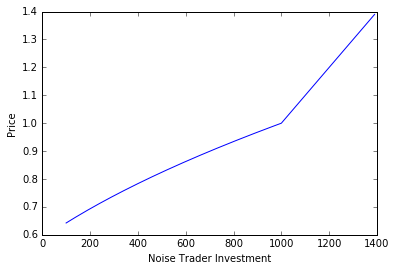

In [31]:
funds = []
Fund.maxLeverage = 50
for shares in range(1, 10):
    f = Fund(20)
    f.shares = shares * 2
    funds.append(f)

noiseTraderInvestments = []
prices = []
for inv in range(10, 140):
    noiseTraderInvestment = inv * 10
    noiseTraderInvestments.append(noiseTraderInvestment)
    prices.append(findEquilibrium(noiseTraderInvestment, funds))

plot.xlabel('Noise Trader Investment')
plot.ylabel('Price')
plot.plot(noiseTraderInvestments, prices)
plot.show()

Questions: what would this curve look like without funds? Why is the curve slightly bent below 1000?

Next, let us see if we can provoke a margin call.

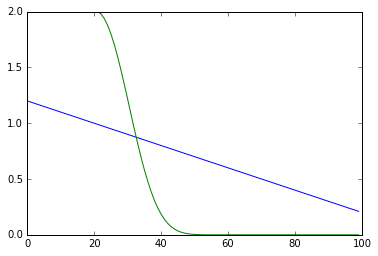

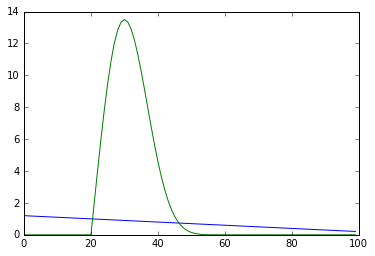

In [32]:
Fund.maxLeverage = 50
fund = Fund(100)

days = []
prices = []
wealth = []
shares = []
for i in range(0,100):
    price = 1.2 - i/100
    fund.trade(price)
    days.append(i)
    prices.append(price)
    wealth.append(fund.getWealth(price))
    shares.append(fund.shares)
    
plot.plot(days, prices, 'b', wealth, 'g')
plot.show()
plot.plot(days, prices, 'b', shares, 'g')
plot.show()


<h2>Intermediate Result</h2>

Before moving on to the background investor, let us test what the stock market looks in a world consisting of only noise traders and funds.

In [94]:
def initializeFunds():
    funds = []
    Fund.maxLeverage = 50
    for beta in range(1, 11):
        funds.append(Fund(beta * 5))
    return funds

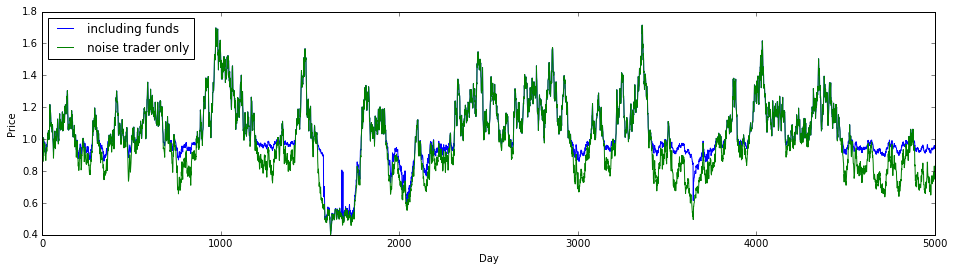

In [72]:
funds = initializeFunds()
days = range(1, 5000)
price = 1
prices = [price]
noiseTraderInvestment = 1000
noiseTraderPrices = [noiseTraderInvestment/N]
fundWealth = []
for day in days:
    for f in funds:
        f.checkBankrupt(price)
    noiseTraderInvestment = calculateNoiseTraderInvestment(noiseTraderInvestment)
    price = findEquilibrium(noiseTraderInvestment, funds)
    totalWealth = 0
    for f in funds:
        f.trade(price)
        totalWealth = totalWealth + f.getWealth(price)
    prices.append(price)
    noiseTraderPrice = min(noiseTraderInvestment/N, maxPrice)
    
    # In the current setup, the market price should always be at least as high as the price without funds
    assert noiseTraderPrice <= price + 0.001, "Price fell to " + str(price) + " which is below the noise trader price of " + str(noiseTraderPrice)
    
    noiseTraderPrices.append(noiseTraderPrice)
    fundWealth.append(totalWealth)

plot.figure(figsize=(16,4))
plot.plot([0] + list(days), prices, 'b', label='including funds')
plot.plot([0] + list(days), noiseTraderPrices, 'g', label='noise trader only')
plot.xlabel('Day')
plot.ylabel('Price')
plot.legend(loc='upper left')
plot.show()


With the funds investing at undervalued prices, the prices do not fall much below the fundamental value. 

As a side effect of following a value stategy, the funds accrue wealth over time, as the following plot shows.

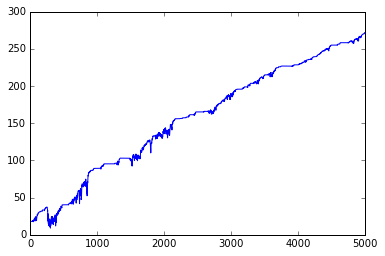

In [41]:
plot.plot(fundWealth)
plot.show()

<h2>Fund Investor</h2>
Fund investors contribute or withdraw money from each fund based on its recent performance $r_h^{perf}(t)$, which is based on a moving average of recent returns $r(t)$, with $a=0.1$:

\begin{align}
    r_h^{perf}(t) = (1-a)~r_h^{perf}(t-1)+a~r_h(t) \tag{5}
\end{align}

\begin{align}
    r(t) = \frac{(\frac{p(t)}{p(t-1)} - 1)~\xi_{h}(t-1))}{W_h(t-1)}
\end{align}

The flow of capital in or out of the fund $F_h(t)$:

\begin{align}
F_h(t) = max\big(\text{-}1,~b~(r_h^{perf}(t) - r^b)\big)~W_h(t) \tag{7}
\end{align}

with $r^b = 0.005$ being a benchmark return and $b = 0.15$ being a sensitivity parameter. The benchmark return can be used to tune how wealthy the funds can grow. With a higher benchmark return, profits are withdrawn sooner and the asymptotic fund size smaller.







In [173]:
# DynamicFund extends Fund by adding inflow/outflow dynamics
class DynamicFund(Fund):
    
    benchmarkPerformance = 0.005 # r^b
    sensitivity = 0.15 # b
        
    def __init__(self, aggressiveness):
        super(DynamicFund, self).__init__(aggressiveness)
        self.performance = 0.0
        self.previousWealth = self.initialWealth
        self.previousInvestment = 0.0
        
    def updatePerformance(self, oldprice, newprice, wealth):
        ret = (newprice/oldprice - 1)*self.previousInvestment/self.previousWealth
        self.performance = 0.9 * self.performance + 0.1 * ret # equation 5
        # remember values for next round
        self.previousInvestment = self.shares * newprice
        self.previousWealth = wealth
        return self.performance
    
    def processInflows(self, oldprice, newprice):
        if self.isActive():
            wealth = self.getWealth(newprice)
            perf = self.updatePerformance(oldprice, newprice, wealth)
            inflow = self.sensitivity*(perf - self.benchmarkPerformance)*wealth
            #inflow = -0.00025*wealth # tax variant
            self.cash += max(inflow, -wealth)
        
        

<h2>Simulation Results</h2>
Yadda yadda

In [92]:
def initializeDynamicFunds():
    funds = []
    Fund.maxLeverage = 50
    for beta in range(1, 11):
        funds.append(DynamicFund(beta * 5))
    return funds

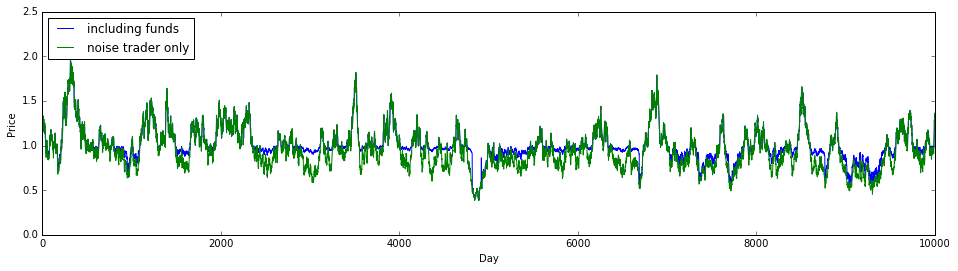

In [171]:
funds = initializeDynamicFunds()
days = range(1, 10000)
oldprice = 1
prices = [oldprice]
noiseTraderInvestment = 1000
noiseTraderPrices = [noiseTraderInvestment/N]
fundWealth = []
for day in days:
    noiseTraderInvestment = calculateNoiseTraderInvestment(noiseTraderInvestment)
    newprice = findEquilibrium(noiseTraderInvestment, funds)
    currentWealth = []
    for f in funds:
        f.trade(newprice)
        bankrupt = f.checkBankrupt(newprice)
        f.processInflows(oldprice, newprice)
        currentWealth.append(f.getWealth(newprice))
           
    prices.append(newprice)
    oldprice = newprice
    noiseTraderPrice = min(noiseTraderInvestment/N, maxPrice)
    
     # In the current setup, the market price should always be at least as high as the price without funds
    assert noiseTraderPrice <= newprice + 0.001, "Price fell to " + str(newprice) + " which is below the noise trader price of " + str(noiseTraderPrice)
       
    noiseTraderPrices.append(noiseTraderPrice)
    fundWealth.append(currentWealth)

plot.figure(figsize=(16,4))
plot.plot([0] + list(days), prices, 'b', label='including funds')
plot.plot([0] + list(days), noiseTraderPrices, 'g', label='noise trader only')
plot.xlabel('Day')
plot.ylabel('Price')
plot.legend(loc='upper left')
plot.show()

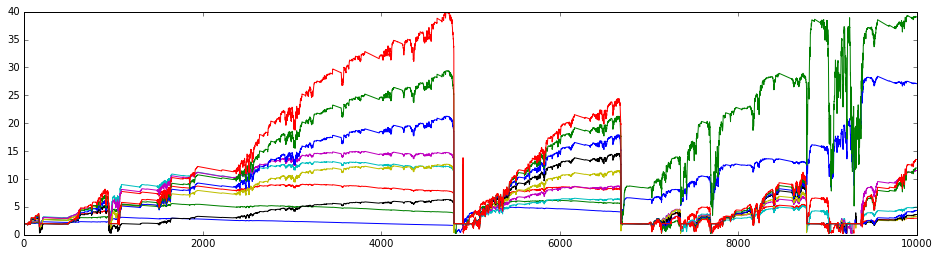

In [172]:
plot.figure(figsize=(16,4))
plot.plot(fundWealth)
plot.show()

<h2>Notes</h2>
The fund investor follows a trend following strategy

